In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [34]:
## implementar a função que identifica a bandeira
## a função deve receber uma imagem e retornar a bandeira identificada
## a função deve retornar uma lista de tuplas, onde cada tupla contém as coordenadas de um dos cantos da bandeira
## [(PAIS, (x1, y2), (x2, y2)`),(PAIS, (x1, y2), (x2, y2)`),(PAIS, (x1, y2), (x2, y2)`),...]

import cv2
import numpy as np

def identifica_bandeira(img):
    resultado = []
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Intervalos de cores HSV mais amplos para detecção inicial
    vermelho_a1 = np.array([10, 255, 255])
    vermelho_b1 = np.array([0, 50, 50])
    vermelho_a2 = np.array([180, 255, 255])
    vermelho_b2 = np.array([160, 50, 50])
    
    branco_a = np.array([180, 40, 255])
    branco_b = np.array([0, 0, 180])
    
    verde_a = np.array([90, 255, 255])
    verde_b = np.array([35, 40, 40])
    
    laranja_a = np.array([25, 255, 255])
    laranja_b = np.array([8, 100, 100])
    
    # Máscaras para todas as cores com morfologia para melhorar a detecção
    kernel = np.ones((5,5), np.uint8)
    
    mask_vermelho = cv2.bitwise_or(
        cv2.inRange(hsv, vermelho_b1, vermelho_a1),
        cv2.inRange(hsv, vermelho_b2, vermelho_a2)
    )
    mask_vermelho = cv2.morphologyEx(mask_vermelho, cv2.MORPH_CLOSE, kernel)
    
    mask_branco = cv2.inRange(hsv, branco_b, branco_a)
    mask_branco = cv2.morphologyEx(mask_branco, cv2.MORPH_CLOSE, kernel)
    
    mask_verde = cv2.inRange(hsv, verde_b, verde_a)
    mask_verde = cv2.morphologyEx(mask_verde, cv2.MORPH_CLOSE, kernel)
    
    mask_laranja = cv2.inRange(hsv, laranja_b, laranja_a)
    mask_laranja = cv2.morphologyEx(mask_laranja, cv2.MORPH_CLOSE, kernel)
    
    # Combinar todas as máscaras para detecção inicial
    mask_combinada = cv2.bitwise_or(
        cv2.bitwise_or(mask_vermelho, mask_branco),
        cv2.bitwise_or(mask_verde, mask_laranja)
    )
    
    # Operações morfológicas para melhorar os contornos
    mask_combinada = cv2.morphologyEx(mask_combinada, cv2.MORPH_CLOSE, kernel)
    mask_combinada = cv2.morphologyEx(mask_combinada, cv2.MORPH_OPEN, kernel)
    
    # Encontrar contornos
    contornos, _ = cv2.findContours(mask_combinada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        
        # Filtro de tamanho baseado na proporção esperada de bandeiras (aproximadamente 2:3)
        if w < 30 or h < 20 or w/h < 0.5 or w/h > 2.0:
            continue
            
        bandeira_region = img[y:y+h, x:x+w]
        bandeira_hsv = hsv[y:y+h, x:x+w]
        
        # Calcular porcentagem de cada cor na bandeira
        mask_vermelho_bandeira = cv2.bitwise_or(
            cv2.inRange(bandeira_hsv, vermelho_b1, vermelho_a1),
            cv2.inRange(bandeira_hsv, vermelho_b2, vermelho_a2)
        )
        mask_branco_bandeira = cv2.inRange(bandeira_hsv, branco_b, branco_a)
        mask_verde_bandeira = cv2.inRange(bandeira_hsv, verde_b, verde_a)
        mask_laranja_bandeira = cv2.inRange(bandeira_hsv, laranja_b, laranja_a)
        
        total_pixels = w * h
        perc_vermelho = cv2.countNonZero(mask_vermelho_bandeira) / total_pixels
        perc_branco = cv2.countNonZero(mask_branco_bandeira) / total_pixels
        perc_verde = cv2.countNonZero(mask_verde_bandeira) / total_pixels
        perc_laranja = cv2.countNonZero(mask_laranja_bandeira) / total_pixels

        print(f"\nRegião detectada: ({x}, {y}, {w}, {h})")
        print(f"Cores: V={perc_vermelho:.2f} B={perc_branco:.2f} Vd={perc_verde:.2f} L={perc_laranja:.2f}")
        
        # Verificar padrões de bandeiras (ordem importa - do mais específico para o mais genérico)
        
        # Itália (verde + branco + vermelho em faixas verticais)
        if perc_verde > 0.3 and perc_branco > 0.3 and perc_vermelho > 0.3 and perc_laranja == 0:
            resultado.append(("Italia", (x, y), (x + w, y + h)))
            continue
        
        # Irlanda (verde + branco + laranja em faixas verticais)
        if perc_verde > 0.3 and perc_branco > 0.3 and perc_laranja > 0.3 and perc_vermelho == 0:
            resultado.append(("Irlanda", (x, y), (x + w, y + h)))
            continue
        
        # Singapura (vermelho + branco)
        if perc_branco > 0.5 and 0.4 < perc_vermelho < 0.5 and perc_verde <= 0 and perc_laranja <= 0:
            resultado.append(("Singapura", (x, y), (x + w, y + h)))
            continue
        
        # Peru (vermelho dominante com branco)
        if perc_vermelho > 0.6 and 0.2 < perc_branco < 0.4 and perc_laranja <= 0 and perc_verde <= 0:
            resultado.append(("Peru", (x, y), (x + w, y + h)))
            continue
        
        # Mônaco (vermelho + branco em proporções iguais)
        if perc_vermelho == 0.5 and perc_branco == 0.5:
            resultado.append(("Monaco", (x, y), (x + w, y + h)))
            continue
    
    return resultado


In [48]:
## nao alterar essa função
# Função para desenhar as bandeiras identificadas
def draw_bandeiras(lista_bandeiras, bgr):
    try:
        for bandeira in lista_bandeiras:
            cv2.rectangle(bgr, bandeira[1], bandeira[2], (245, 233, 10), 5)
            cv2.putText(bgr, bandeira[0], bandeira[1], cv2.FONT_HERSHEY_SIMPLEX, 1, (245, 233, 10), 2, cv2.LINE_AA)
        return bgr
    except Exception as e:
        return bgr


Região detectada: (192, 496, 265, 177)
Cores: V=0.48 B=0.52 Vd=0.00 L=0.00

Região detectada: (726, 163, 258, 206)
Cores: V=0.50 B=0.50 Vd=0.00 L=0.00

Região detectada: (119, 121, 262, 175)
Cores: V=0.67 B=0.33 Vd=0.00 L=0.00
[('Singapura', (192, 496), (457, 673)), ('Monaco', (726, 163), (984, 369)), ('Peru', (119, 121), (381, 296))]


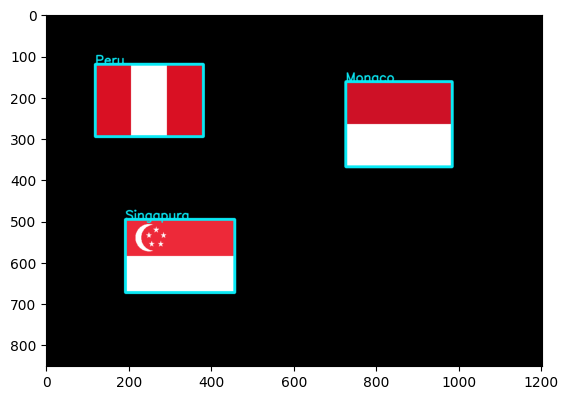

In [49]:
## Para testar a função identifica_bandeira

# Você pode testar a função identifica_bandeira com as imagens de teste fornecidas
# 
img = cv2.imread('img/teste1.png')
# img = cv2.imread('img/teste2.png')
# img = cv2.imread('img/teste3.png')
# img = cv2.imread('img/teste4.png')

# Chamar a função identifica_bandeira
resultado = identifica_bandeira(img)

# Imprimir o resultado da função identifica_bandeira 
print(resultado)

# Desenhar as bandeiras na imagem
bgr = draw_bandeiras(resultado, img)
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
plt.show()